# Libraries

In [41]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from pathlib import Path
import sys

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

# %matplotlib ipympl
%matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [28]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_analog, rf_tx_fw, tonegen, digital_filter_design, digital_hw_algo as dighw

reload(calc)
reload(ofdm)
reload(rf_analog)
reload(rf_tx_fw)
reload(tonegen)
reload(digital_filter_design)
reload(dighw)

<module 'rfdsppy.digital_hw_algo' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/digital_hw_algo.py'>

# Halfband as AAF

In [49]:
# Generate waveforms

R = 2 # Downsample by 2
pdelta = 10 # Power delta in dB for downsampling example (blocker minus desired)

# Desired signal
nsym = 14*10
modorder = 64
bw = 20
scs = 15
num_sc = 1200
start_sc = 600-round(num_sc/2)
en_tprecode = False
osr = R*2
wola = 1
sig_power = -19
sig_wg = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr, wola=wola, power=sig_power)

x_signal, x_standard = sig_wg.generate(nsym)
cfg = sig_wg.get_demod_params()
fs_in = cfg.get("fs")
wola_len = cfg.get("wola_len")

# Blocker
num_sc_block = 100
start_sc_block = round((100*12-num_sc_block)/2)
block_wg = ofdm.OFDMWavGen(bw, scs, modorder, start_sc_block, num_sc=num_sc_block, en_tprecode=en_tprecode, osr=osr, wola=wola, power=sig_power+pdelta)
x_blocker, _ = block_wg.generate(nsym)
w_blocker = 2*np.pi/R
x_blocker = x_blocker*np.exp(1j*w_blocker*np.arange(x_blocker.size)) # Frequency shift blocker to correct location

# Add signal and blocker
x = x_signal+x_blocker

digital_filter_design.firls_rate_change()
Largest passband ripple (dB) = 0.0
Smallest stopband rejection (dB) = 104.1



EVM: 0.01%


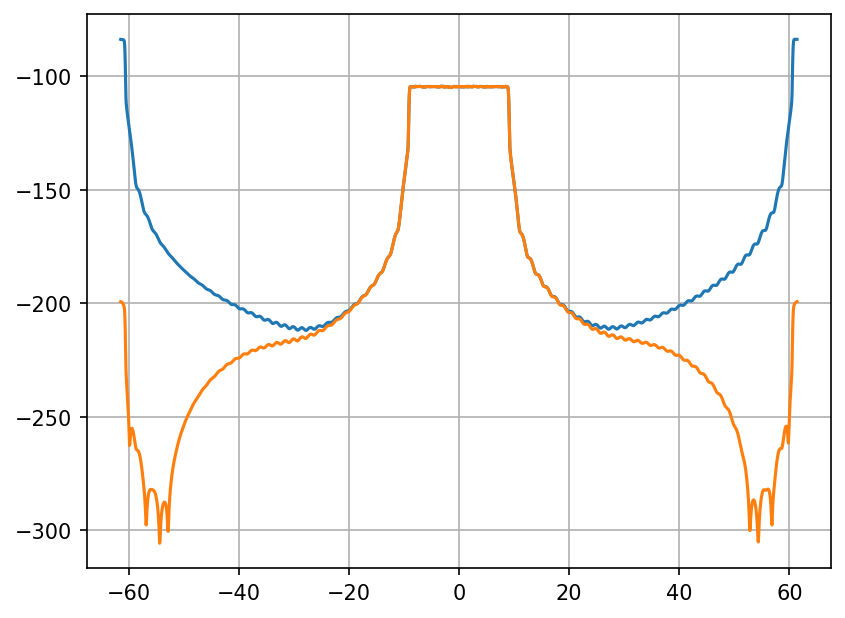

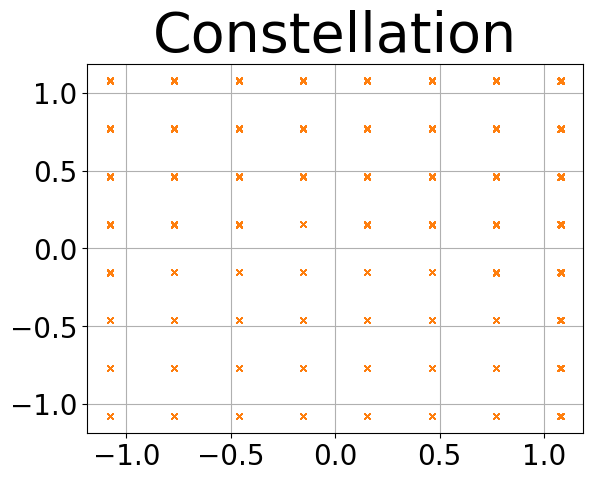

In [50]:
ntaps = 15
obw = num_sc*scs/1000
b = digital_filter_design.firls_rate_change('down', ntaps, obw, fs_in, R, en_plot=False)
b = b/b.sum()

y = signal.lfilter(b, 1, x)

fig, axs = plt.subplots(dpi=150)

py, f = calc.psd(y, fs_in, fs_in/2048)
px, _ = calc.psd(x, fs_in, fs_in/2048)
axs.plot(f, 10*np.log10(px), label="Filter Input")
axs.plot(f, 10*np.log10(py), label="Filter Output")
axs.grid()

evm = sig_wg.calculate_evm(x[round(wola_len/2):], y[round((wola_len+ntaps-1)/2):], en_plot=True)
print(f"EVM: {round(evm,2)}%")

# Halfband Coefficients

[ -868     0  1445     0 -3061     0 10286 16384 10286     0 -3061     0
  1445     0  -868]


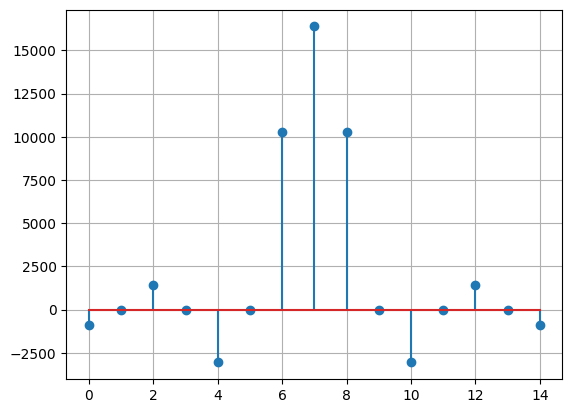

In [67]:
b = signal.firls(15, [0, 0.4, 0.6, 1], [1, 1, 0, 0], fs=2)
b = signal.remez(15, [0, 0.4, 0.6, 1], [1, 0], fs=2)

b = np.round(b*(2**15-1))
print(b.astype("int"))
fig, ax = plt.subplots(dpi=100)

ax.stem(b)
ax.grid()

array([ -551,     0,  1319,     0, -2973,     0, 10254, 16383, 10254,
           0, -2973,     0,  1319,     0,  -551])